In [6]:
import IPython
IPython.auto_scroll_threshold = 9999

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML

%load_ext autoreload
%autoreload 2
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.39 ms


In [7]:
from pyspark.sql.functions import *
from pyspark.sql import Window

time: 607 µs


In [8]:
import numpy as np
import pandas as pd

time: 566 µs


In [9]:
from financials import get_security_returns, group_by_period
from spark import fillna

time: 8.4 ms


In [10]:
from spark import init_spark_context, load_and_get_table_df

sc, sql_context = init_spark_context("Factor Analysis Job - FF Risk Factors")

time: 3.38 s


### The Portfolio Variance

The risk of a portfolio is being manage by the volatility of it. $Var(r_p)$.

The formula that helps us control the volatility of a given portfolio (weights on each stock) is defined by the following algebra of matrices:

$$ Var(r_p) = X^T (BFB^T + S) X $$

where:

- Matrix $X$ is a vector with the weights of the stocks in our portfolio. Shape: (1, N) N = number of companies
- Matrix $B$ is the matrix of factor exposures. Represents the exposures of each stock to each of the beta factors of our model. In our case the exposure of the stocks to the three factors proposed by Fama and French: $f_m$, $f_s$, and $f_v$.
- Matrix $F$ is the covariance matrix between all the factors ($f_m$, $f_s$, and $f_v$.).
- Matrix $S$ is the specific variance matrix. And it holds the variance for each stock that is not contributable to the risk factors, the residuals.

In [11]:
# The dates of the analysis
start_analysis_date = "2007-12-01"
end_analysis_date = "2015-12-31"


# Ontain the list of companies in our universe
universe = load_and_get_table_df(sql_context, "tfm_uoc_analysis", "portfolio_universe")
universe.cache()

DataFrame[ccvm: string, ticker: string, EBIT: decimal(38,18), EarningsYield: double, ROC: decimal(38,18), astodate: date, cash: decimal(38,18), current_assets: decimal(38,18), current_liabilities: decimal(38,18), current_non_cash_assets: decimal(38,18), dividend: double, excess_cash: decimal(38,18), fixed_liabilities: decimal(38,18), liquidity120days: double, marketcap: double, price_share: float, quality_index: double, short_term_investments: decimal(38,18), solr_query: string, stock: decimal(38,18), total_cash: decimal(38,18), total_debt: decimal(38,18), total_shares: decimal(38,18)]

time: 2.29 s


# Compute the matrix $F$

The matrix $F$ represents the covariance matrix of factors. Once we have the factors time series computed 

In [12]:
def get_factor_returns(sql_context):
    ff_factor_returns_pd = load_and_get_table_df(sql_context, "tfm_uoc_analysis", "ff_factors")
    ff_factor_returns_pdf = ff_factor_returns_pd.toPandas()
    ff_factor_returns_pdf = ff_factor_returns_pdf[["date", "market_factor", "SMB", "HML"]]. \
        sort_values(['date'], ascending=[1])
    ff_factor_returns_pdf = ff_factor_returns_pdf.set_index("date")
    return ff_factor_returns_pdf


def get_factors_covariance_matrix(sql_context, ann_factor):
    """
    Covariance matrix of factors. We load from the database the 
    3 time series factors of Fama and French generated in a previous notebook.
    
    Based on the time series of the factors, a covariance matrix is being
    computed.
    """
    return get_factor_returns(sql_context).cov()*ann_factor

time: 1.59 ms


In [13]:
# Set the annualized factor
ann_factor = 252

matrix_F = get_factors_covariance_matrix(sql_context=sql_context, ann_factor=252)
matrix_F

,market_factor,SMB,HML
market_factor,4.732575,9.622494,3.099911
SMB,9.622494,37.224639,9.466840
HML,3.099911,9.466840,5.695761


time: 1.3 s


# The factor exposures matrix $B$

The matrix $B$ represents the matrix of factor exposures to the factors of our risk model ($f_m$, $f_s$, and $f_v$.).

we already computed that in the iPython Notebook `Fama and French Risk Model`. Here we need only to load the computed exposures for each stock (company).

In [14]:
def get_factor_exposures(sql_context):
    factor_exposures = load_and_get_table_df(sql_context, "tfm_uoc_analysis", "ff_factor_exposures")
    factor_exposures_pdf = factor_exposures.toPandas()
    factor_exposures_pdf = factor_exposures_pdf[["ticker", "market_factor", "SMB", "HML"]]. \
        sort_values(['ticker'], ascending=[1])
    factor_exposures_pdf = factor_exposures_pdf.set_index("ticker")
    return factor_exposures_pdf

# We get the B 
factor_exposures = get_factor_exposures(sql_context)
factor_exposures

,market_factor,SMB,HML
ticker,,,
ABEV3,0.177119,0.136733,-0.000949
BBAS3,0.605385,0.404526,-0.379324
BBSE3,0.207940,0.842879,0.074099
BEEF3,-0.378388,0.757128,0.323197
BRAP3,0.513366,0.305610,-0.200856
BRAP4,0.235591,0.359325,-0.458641
BRFS3,-0.007243,0.209886,0.022592
BRML3,0.533634,0.302840,-0.276423
BRPR3,-0.091767,0.361969,0.224448


time: 352 ms


In [15]:
factor_exposures.shape

(37, 3)

time: 5.62 ms


## Compute the matrix $S$

For the specific variance matrix, we need to compute the specific return for each stock during the period of analysis. 

The specific return for each day can be computed by $s_i = r_{i, actual} - r_{i, estimated}$. The actual return of the stock for the specific day minus the estimated return for that same day. 

We compute the estimated return using the factor exposures of the stock and the factor returns for the specific day.

$$ r_{i, estimated} = (\beta_{i, m} x f_m) + (\beta_{i, s} x f_s) + (\beta_{i, v} x f_v) $$

Getting the variance of the specific returns ($Var(s_i),..., Var(s_N), etc.$) gives us the input in the matrix of specific variances, that it's a diagonal matrix.

$$
\begin{pmatrix}
Var(s_i) & 0 & 0\\
0 & ... & 0 \\
0 & 0 & Var(s_N)
\end{pmatrix}
$$

where `N` are the number of stocks (companies)

Steps:

1. $actual_returns$, get the actual returns from the historic stock prices, the dates of the analysis, and frequency (quarterly)
2. $common_returns$, compute the part of the returns explained by the risk factors, that is, compute the expected returns using the factor returns (the time series with the returns by each factor) and the factor exposures for each stock.
3. $specific_returns$, the difference between the actual returns and the common returns, that gives us the residuals. The part of the returns not explained by the risk factors (alpha)
4. $variance_specific_returns$ we compute the variance of the residuals for each stock and annualize the values multiplying by 252 trading days.
5. $idiosyncratic\_matrix$ we create a diagonal matrix with all zeros except the diagonal that will contains the variance of each stock. Index and Columns are composed by the stocks.


In [16]:
def get_actual_returns(sql_context, universe, start_date, end_date, frequency="quarterly"):
    """
    This function is resposible by compute the returns of the stocks in our
    restricted universer between the giving dates.
    
    :param universe: the restricted universe. We expect an Spark DataFrame
        with, at least, the column `ccvmn` in it.
    :param start_date: the start date of the analysis
    :param end_date: the end date of the analysis
    :param frequency: the frequency we want to use to generate the returns.
        By default we work with a `quarterly` frequency, as it's the 
        frequency of the fundamental data points.
    """

    # Loading the security prices on the database. That's the historical
    # prices of all the stocks in our restricted universe
    universe_stock_prices = load_and_get_table_df(
        sql_context, "tfm_uoc_analysis", "security_prices").join(
        universe.select(col("ccvm")),
        "ccvm", how='right')

    # We filter the time series to maintain the prices between the
    # start and end dates, both included.
    universe_stock_prices = universe_stock_prices. \
        filter((col("date") >= start_date) & (col("date") <= end_date)). \
        orderBy(["date", "ccvm", "ticker"], ascending=[True, True, True])

    # We group the data by frequency, getting the last price at the period
    universe_stock_prices_Q = group_by_period(
        universe_stock_prices,
        columns=["close", "high", "low", "open", "adjclose", "volume"],
        columns_aliases=["close", "high", "low", "open", "adjclose", "volume"],
        columns_agg=[last, last, last, last, last, last, last],
        date_field="date",
        group_columns=["ccvm", "ticker", "type"],
        frequency=frequency
    )

    # We compute the log returns of the stocks between the periods (frequency)
    universe_stock_returns_Q = get_security_returns(universe_stock_prices_Q, ct_price_field="adjclose")

    # We fill any missing value (or NaN) with the previous value available in the series
    # This is a fill forward strategy.
    universe_stock_returns_Q_filled = fillna(universe_stock_returns_Q, 
           partition_keys=["ccvm", "ticker", "type"], 
           order_field="date", 
           field_to_fill="adjclose_returns",
           fill_function=last)

    # We pivot the dataframe to have the names of the stocks as columns
    # and each rows an date entry in the time series. All ordered from older to
    # newer data points. Each cell represents the return of the given stock (column)
    # in the given date (row)
    actual_returns = universe_stock_returns_Q_filled.groupBy(col("date")). \
        pivot("ticker").sum("adjclose_returns_filled"). \
        orderBy(["date"], ascending=[True])

    actual_returns_pdf = actual_returns.toPandas()
    actual_returns_pdf = actual_returns_pdf. \
        sort_values(['date'], ascending=[True])
    actual_returns_pdf = actual_returns_pdf.set_index("date")
    
    return actual_returns_pdf.iloc[1:]

time: 10.1 ms


In [17]:
# Obtain the actual returns
actual_returns_pdf = get_actual_returns(
    sql_context=sql_context,
    universe=universe, 
    start_date=start_analysis_date,
    end_date=end_analysis_date)

actual_returns_pdf.head()

,ABEV3,BBAS3,BBSE3,BEEF3,BRAP3,BRAP4,BRFS3,BRML3,BRPR3,CCRO3,...,QUAL3,RENT3,TOTS3,UGPA3,USIM3,USIM5,VALE3,VIVT3,VIVT4,VLID3
date,,,,,,,,,,,,,,,,,,,,,
2008-03-31,-0.068078,-0.239803,NaN,-0.294813,-0.096505,-0.005252,-0.091731,-0.348334,NaN,-0.058546,...,NaN,-0.108342,0.018950,NaN,0.254093,0.230258,0.020065,-0.152688,-0.015487,0.028603
2008-06-30,0.171258,0.131545,NaN,0.096774,-0.075865,-0.074340,0.080853,-0.008951,NaN,0.224025,...,NaN,0.111285,-0.026030,NaN,0.104464,0.204268,-0.044424,0.027919,0.007867,0.012271
2008-09-30,0.155606,-0.130020,NaN,-0.582353,-0.383721,-0.390828,-0.157602,-0.258066,NaN,-0.087843,...,NaN,-0.435382,-0.141055,NaN,-0.478917,-0.471900,-0.363240,-0.041976,-0.003567,-0.096976
2008-12-31,-0.075657,-0.354725,NaN,-0.478873,-0.302264,-0.281648,-0.182967,-0.208694,NaN,-0.054800,...,NaN,-0.255810,-0.102664,NaN,-0.325945,-0.345347,-0.238187,-0.046392,0.022824,-0.278521
2009-03-31,0.214212,0.149183,NaN,-0.070270,0.076257,0.136601,-0.033288,0.582415,NaN,-0.117647,...,NaN,0.142251,0.177651,0.064568,0.025145,0.061463,0.119538,0.055751,0.054255,-0.051163


time: 1min 4s


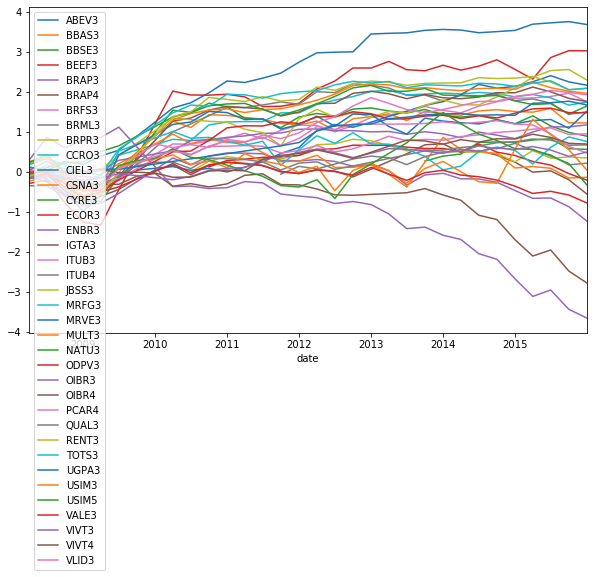

time: 1.23 s


In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [10.0, 6.0]
#market_factor_pd = market_factor_pd.set_index("date")
actual_returns_pdf.cumsum().plot();

In [34]:
import altair as alt

chart_actual_returns_pdf = pd.melt(actual_returns_pdf.reset_index(), 
        id_vars=['date'], 
        value_vars=list(actual_returns_pdf.columns), 
        var_name='ticker', value_name='returns')

chart_actual_returns_pdf['date'] = pd.to_datetime(
    chart_actual_returns_pdf['date'], format='%Y-%m-%d')

chart_actual_returns_pdf["cumsum_returns"] = \
    chart_actual_returns_pdf.groupby(['ticker'])['returns'].cumsum()

actual_returns_line = alt.Chart(chart_actual_returns_pdf). \
    mark_line().encode(
    x=alt.X('date', axis=alt.Axis(title='Quarter')),
    y=alt.Y('cumsum_returns', axis=alt.Axis(title='Returns', format='.0%')),
    color=alt.Color('ticker', legend=alt.Legend(title="Symbol")))

actual_returns_line

alt.Chart(...)

time: 40.4 ms


In [19]:
# Obtain the factor returns
factor_returns_pdf = get_factor_returns(sql_context)

factor_returns_pdf.head()

,market_factor,SMB,HML
date,,,
2008-03-31,-0.045675,-0.064823,0.009818
2008-06-30,-0.058222,0.069703,0.066601
2008-09-30,-0.182624,-0.669783,0.056483
2008-12-31,-0.135770,-0.766986,-0.142097
2009-03-31,0.105830,0.287732,-0.003165


time: 196 ms


In [20]:
def get_expected_returns(factor_returns, factor_exposures):
    """
    Function to compute the predicted returns based on the time series of the factor returns
    and the factor exposure of each stock.
    
    :param factor_returns: a matrix with as many columns as factors we are using in the
        risk model, and as many rows as dates that are part of the analysis. 
        Shape: D, F - Where D is the number of dates and F the number of factors.
        Cells: the return of the factor $F_i$ for the given date $D_i$
    :param factor_exposures: a matrix with as many columns as factors we are using in the
        risk model, and as many rows as stocks we have in our universe. Each row contains
        information of the betas associated to the exposure of the giving stock to each
        factor.
        Shape: N, F - Where N is the number of stocks and N the number of factors.
        Cells: exposure of stock $N_i$ to the factor $F_j$
        
    :return: a matrix with as many columns as stocks we have and as many rows as dates that
        are part of the analysis. Each cell contains the predicted return of the stock in
        the giving date. 
        Shape: M, P - Where M is the number of dates and P the number of stocks. 
        Cells: the expected value of the stock $N_i$ to the factor $F_j$
    """
    expected_returns = np.dot(factor_returns_pdf, factor_exposures.T)
    return pd.DataFrame(expected_returns, index=factor_returns.index, columns=factor_exposures.index)

time: 952 µs


In [21]:
expected_returns_pdf = get_expected_returns(factor_returns_pdf, factor_exposures)
expected_returns_pdf.head()

ticker,ABEV3,BBAS3,BBSE3,BEEF3,BRAP3,BRAP4,BRFS3,BRML3,BRPR3,CCRO3,...,QUAL3,RENT3,TOTS3,UGPA3,USIM3,USIM5,VALE3,VIVT3,VIVT4,VLID3
date,,,,,,,,,,,,,,,,,,,,,
2008-03-31,-0.016963,-0.057598,-0.063408,-0.028623,-0.045231,-0.038556,-0.013053,-0.046719,-0.017069,-0.010597,...,-0.025733,-0.037760,-0.016106,-0.001893,-0.057166,-0.051509,-0.037299,-0.006929,-0.007592,-0.008862
2008-06-30,-0.000845,-0.032314,0.051579,0.096330,-0.021965,-0.019217,0.016556,-0.028371,0.045522,0.020229,...,-0.023817,0.028321,0.033237,-0.004788,-0.049823,-0.005911,-0.025733,-0.008684,-0.025090,0.034475
2008-09-30,-0.123981,-0.402929,-0.598336,-0.419754,-0.309790,-0.309600,-0.137979,-0.315905,-0.213004,-0.064980,...,-0.129697,-0.357316,-0.167808,-0.007949,-0.387803,-0.555559,-0.251088,-0.021784,-0.017389,-0.066182
2008-12-31,-0.128785,-0.338558,-0.685238,-0.575259,-0.275557,-0.242412,-0.163207,-0.265447,-0.297059,-0.145012,...,-0.110886,-0.400529,-0.242270,0.001971,-0.276250,-0.416104,-0.201741,-0.019893,0.029817,-0.180364
2009-03-31,0.058090,0.181664,0.264295,0.176782,0.142899,0.129773,0.059553,0.144486,0.093728,0.042753,...,0.068202,0.156566,0.078413,0.003458,0.170688,0.207126,0.113860,0.015055,0.008804,0.045240


time: 15.8 ms


In [35]:
import altair as alt

chart_expected_returns_pdf = pd.melt(expected_returns_pdf.reset_index(), 
        id_vars=['date'], 
        value_vars=list(expected_returns_pdf.columns), 
        var_name='ticker', value_name='returns')

chart_expected_returns_pdf['date'] = pd.to_datetime(
    chart_expected_returns_pdf['date'], format='%Y-%m-%d')

chart_expected_returns_pdf["cumsum_returns"] = \
    chart_expected_returns_pdf.groupby(['ticker'])['returns'].cumsum()

expected_returns_line = alt.Chart(chart_expected_returns_pdf). \
    mark_line().encode(
    x=alt.X('date', axis=alt.Axis(title='Quarter')),
    y=alt.Y('cumsum_returns', axis=alt.Axis(title='Returns', format='.0%')),
    color=alt.Color('ticker', legend=alt.Legend(title="Symbol")))

expected_returns_line

alt.Chart(...)

time: 78.8 ms


In [22]:
def get_specific_returns(actual_returns, expected_returns):
    """
    Computes the part of the returns not explained by the factors. The residuals.
    That's the difference between the actual returns and the expected returns.
    """
    specific_returns = actual_returns - expected_returns
    return pd.DataFrame(specific_returns, index=actual_returns.index, columns=actual_returns.columns)

time: 836 µs


In [23]:
specific_returns = get_specific_returns(actual_returns_pdf, expected_returns_pdf)
specific_returns.head()

,ABEV3,BBAS3,BBSE3,BEEF3,BRAP3,BRAP4,BRFS3,BRML3,BRPR3,CCRO3,...,QUAL3,RENT3,TOTS3,UGPA3,USIM3,USIM5,VALE3,VIVT3,VIVT4,VLID3
date,,,,,,,,,,,,,,,,,,,,,
2008-03-31,-0.051116,-0.182205,NaN,-0.266190,-0.051274,0.033304,-0.078678,-0.301615,NaN,-0.047949,...,NaN,-0.070582,0.035056,NaN,0.311259,0.281767,0.057363,-0.145759,-0.007894,0.037466
2008-06-30,0.172103,0.163858,NaN,0.000444,-0.053900,-0.055123,0.064297,0.019420,NaN,0.203795,...,NaN,0.082964,-0.059267,NaN,0.154287,0.210180,-0.018691,0.036602,0.032957,-0.022204
2008-09-30,0.279587,0.272909,NaN,-0.162599,-0.073931,-0.081228,-0.019623,0.057840,NaN,-0.022863,...,NaN,-0.078065,0.026752,NaN,-0.091114,0.083659,-0.112153,-0.020191,0.013821,-0.030794
2008-12-31,0.053128,-0.016167,NaN,0.096385,-0.026707,-0.039236,-0.019760,0.056753,NaN,0.090212,...,NaN,0.144719,0.139606,NaN,-0.049695,0.070757,-0.036445,-0.026498,-0.006994,-0.098157
2009-03-31,0.156122,-0.032481,NaN,-0.247052,-0.066642,0.006827,-0.092841,0.437929,NaN,-0.160400,...,NaN,-0.014315,0.099238,0.06111,-0.145543,-0.145663,0.005678,0.040696,0.045451,-0.096403


time: 19.5 ms


In [36]:
import altair as alt

chart_specific_returns_pdf = pd.melt(specific_returns.reset_index(), 
        id_vars=['date'], 
        value_vars=list(specific_returns.columns), 
        var_name='ticker', value_name='returns')

chart_specific_returns_pdf['date'] = pd.to_datetime(
    chart_specific_returns_pdf['date'], format='%Y-%m-%d')

chart_specific_returns_pdf["cumsum_returns"] = \
    chart_specific_returns_pdf.groupby(['ticker'])['returns'].cumsum()

specific_returns_line = alt.Chart(chart_specific_returns_pdf). \
    mark_line().encode(
    x=alt.X('date', axis=alt.Axis(title='Quarter')),
    y=alt.Y('cumsum_returns', axis=alt.Axis(title='Returns', format='.0%')),
    color=alt.Color('ticker', legend=alt.Legend(title="Symbol")))

specific_returns_line

alt.Chart(...)

time: 36 ms


In [24]:
def idiosyncratic_var_matrix(actual_returns, factor_returns, factor_exposures, ann_factor):
    
    common_returns_ = get_expected_returns(factor_returns, factor_exposures)
    
    residuals_ = get_specific_returns(actual_returns, common_returns_)
    
    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor, actual_returns.columns, actual_returns.columns)

time: 921 µs


In [25]:
idiosyncratic_var_matrix = idiosyncratic_var_matrix(
    actual_returns_pdf, factor_returns_pdf, factor_exposures, ann_factor)

idiosyncratic_var_matrix.head()

,ABEV3,BBAS3,BBSE3,BEEF3,BRAP3,BRAP4,BRFS3,BRML3,BRPR3,CCRO3,...,QUAL3,RENT3,TOTS3,UGPA3,USIM3,USIM5,VALE3,VIVT3,VIVT4,VLID3
ABEV3,3.701354,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,0.000000,3.408924,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBSE3,0.000000,0.000000,0.864087,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BEEF3,0.000000,0.000000,0.000000,12.159338,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BRAP3,0.000000,0.000000,0.000000,0.000000,2.856988,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 18.5 ms


## Save the values for future use

We will save all the matrix to use them later when we were fomulating the optimization problem.

In [26]:
matrix_F.to_csv("F_matrix_factors_covariance_matrix.csv")

factor_exposures.to_csv("B_matrix_factor_exposures.csv")

idiosyncratic_var_matrix.to_csv("S_matrix_idiosynchratic_variances.csv")

time: 21.3 ms


In [27]:
sc.stop()

time: 729 ms
